In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# Check device (use GPU if available, otherwise use CPU)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



# Define Paths

In [4]:

input_dir = "/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment03/Small_data_set/data"
output_dir = "/content/drive/MyDrive/A_deep_learning_lab/ATDL_Assignment03/Small_data_set/segformer_out_put_ATDL_Assignment3"
training_dir = os.path.join(input_dir, "train")
validation_dir = os.path.join(input_dir, "val")
output_training_dir = os.path.join(output_dir, "training")

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_training_dir, exist_ok=True)

In [5]:
output_visualization_dir = os.path.join(output_dir, "visualize_predictions")

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_training_dir, exist_ok=True)
os.makedirs(output_visualization_dir, exist_ok=True)



# Custom Dataset Class for CityScapes

In [6]:
class CityScapesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.sample_images = sorted(os.listdir(os.path.join(root_dir, "image")))
        self.depth_images = sorted(os.listdir(os.path.join(root_dir, "depth")))
        self.label_images = sorted(os.listdir(os.path.join(root_dir, "label")))
        self.transform = transform

    def __len__(self):
        return len(self.sample_images)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.root_dir, "image", self.sample_images[idx])
        depth_path = os.path.join(self.root_dir, "depth", self.depth_images[idx])
        label_path = os.path.join(self.root_dir, "label", self.label_images[idx])

        sample_image = np.load(sample_path).astype(np.float32)
        depth_image = np.load(depth_path).astype(np.float32)
        label_image = np.load(label_path).astype(np.float32)
        label_image[label_image == -1] = 0



        if self.transform:
            sample_image = self.transform(sample_image)
            depth_image = self.transform(depth_image)
            label_image = self.transform(label_image)

        return sample_image, depth_image, label_image



# Define Transformations

In [7]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 1024))
])

# Load Dataset

In [33]:
train_dataset = CityScapesDataset(training_dir, transform=transform)
val_dataset = CityScapesDataset(validation_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)

# Visualize a few mask samples from train and val

In [12]:
def visualize_samples(loader, title="Sample Images", save_path=None):
    images, depths, labels = next(iter(loader))
    fig, axs = plt.subplots(3, 3, figsize=(10, 8))
    for i in range(3):
        axs[i, 0].imshow(images[i].permute(1, 2, 0))
        axs[i, 0].set_title(f"Image {i}")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(depths[i][0], cmap='gray')
        axs[i, 1].set_title(f"Depth {i}")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(labels[i][0], cmap='gray')
        axs[i, 2].set_title(f"Label {i}")
        axs[i, 2].axis("off")

    plt.suptitle(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()


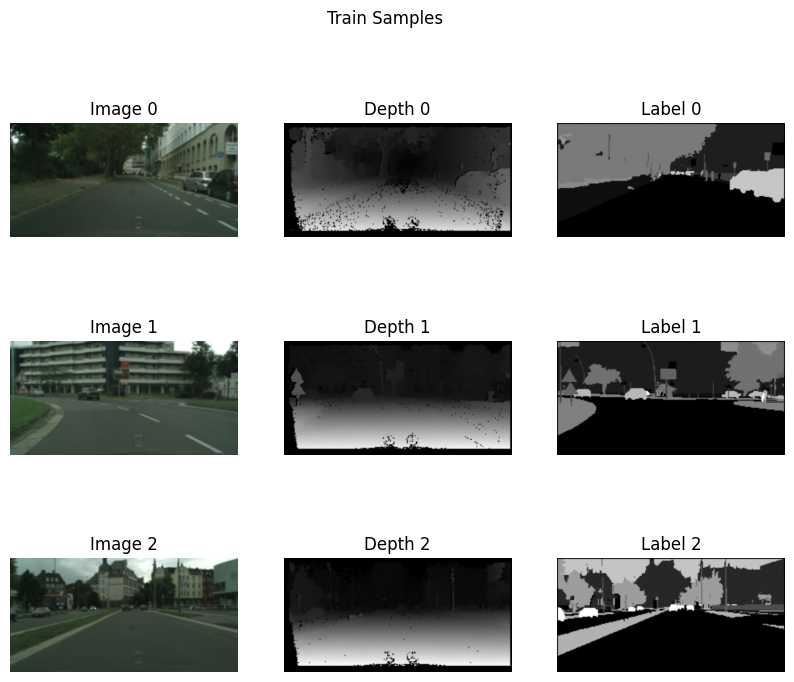

In [13]:
visualize_samples(train_loader, "Train Samples", os.path.join(output_dir, "train_samples.png"))

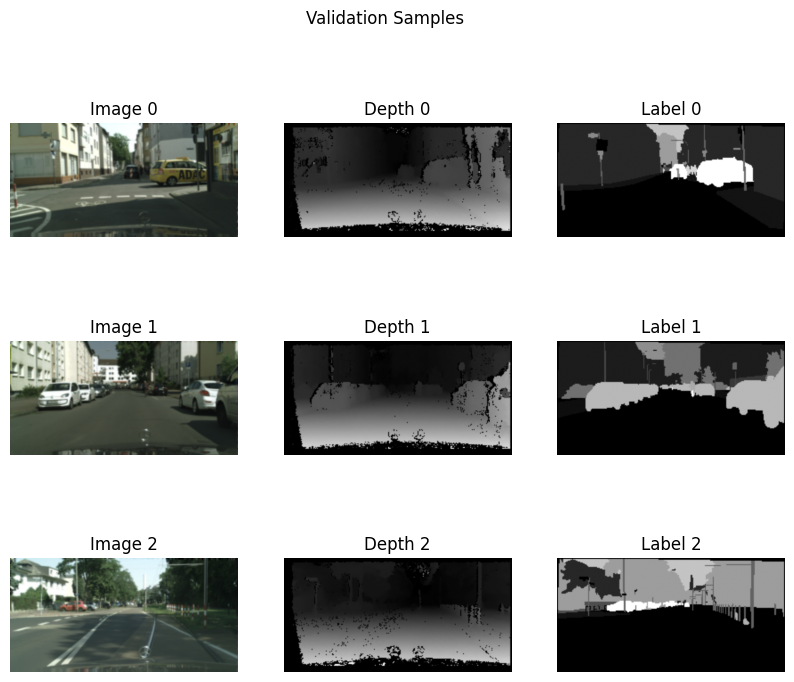

In [14]:
visualize_samples(val_loader, "Validation Samples", os.path.join(output_dir, "val_samples.png"))

In [15]:
print("Visualization complete.")

Visualization complete.


# Load Pretrained SegFormer Model

In [18]:

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")
model.to(device)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)



# Define Optimizer and Loss

In [21]:

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=255)


print("Model loaded successfully and ready for training.")

Model loaded successfully and ready for training.


# Training Function

In [22]:
def train_model(model, train_loader, val_loader, epochs=20):
    best_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, _, labels in train_loader:
            images, labels = images.to(device).float(), labels.to(device).squeeze(1).long()
            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits
            outputs = torch.nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _, labels in val_loader:
                images, labels = images.to(device).float(), labels.to(device).squeeze(1).long()
                outputs = model(pixel_values=images).logits
                outputs = torch.nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save Best Model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(output_training_dir, "best_model.pth"))

    return train_losses, val_losses




# Train the Model

In [23]:
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=3)

Epoch [1/3], Train Loss: 7.9254, Val Loss: 8.0460
Epoch [2/3], Train Loss: 4.3582, Val Loss: 5.5049
Epoch [3/3], Train Loss: 2.7211, Val Loss: 3.9438


# Save Training Logs

In [24]:
np.save(os.path.join(output_training_dir, "train_losses.npy"), np.array(train_losses))
np.save(os.path.join(output_training_dir, "val_losses.npy"), np.array(val_losses))
with open(os.path.join(output_dir, "training_log.txt"), "w") as f:
    for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        f.write(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}\n")

print("Training completed successfully.")


Training completed successfully.


# Load Best Trained Model

In [25]:

best_model_path = os.path.join(output_training_dir, "best_model.pth")
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Best trained model loaded successfully.")
else:
    print("Warning: No trained model found. Proceeding with the pre-trained model.")


<ipython-input-25-e84eb19c4707>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


Best trained model loaded successfully.



# Evaluation Function

In [26]:
def evaluate_model(model, val_loader):
    model.eval()
    iou_per_class = {}
    pixel_accuracies = []
    num_classes = 19  # Adjust based on dataset classes
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, _, labels in val_loader:
            images, labels = images.to(device).float(), labels.to(device).long()
            outputs = model(pixel_values=images).logits
            outputs = torch.argmax(outputs, dim=1)

            if outputs.shape != labels.shape:
                outputs = torch.nn.functional.interpolate(outputs.unsqueeze(1).float(), size=labels.shape[-2:], mode='nearest').squeeze(1).long()

            intersection = (outputs == labels) & (labels > 0)
            union = (outputs > 0) | (labels > 0)

            for class_id in range(num_classes):
                class_intersection = intersection[labels == class_id].sum().item()
                class_union = union[labels == class_id].sum().item()

                if class_union > 0:
                    iou_per_class[class_id] = class_intersection / class_union
                else:
                    iou_per_class[class_id] = 0.0

            total_correct += (outputs == labels).sum().item()
            total_pixels += labels.numel()

        pixel_accuracy = total_correct / total_pixels
        mean_iou = np.mean(list(iou_per_class.values()))
        mean_pixel_accuracy = np.mean(list(pixel_accuracies)) if pixel_accuracies else pixel_accuracy

    print(f"Mean IoU: {mean_iou:.4f}, Pixel Accuracy: {pixel_accuracy:.4f}, Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")
    print("IoU per class:")
    for class_id, iou in iou_per_class.items():
        print(f"Class {class_id}: IoU = {iou:.4f}")

    return mean_iou, pixel_accuracy, mean_pixel_accuracy, iou_per_class

# Evaluate Model

In [29]:
iou, pixel_acc, mean_pixel_acc, iou_per_class = evaluate_model(model, val_loader)


Mean IoU: 0.0392, Pixel Accuracy: 0.1839, Mean Pixel Accuracy: 0.1839
IoU per class:
Class 0: IoU = 0.0000
Class 1: IoU = 0.0004
Class 2: IoU = 0.0909
Class 3: IoU = 0.0000
Class 4: IoU = 0.4970
Class 5: IoU = 0.0000
Class 6: IoU = 0.0098
Class 7: IoU = 0.0000
Class 8: IoU = 0.0000
Class 9: IoU = 0.0000
Class 10: IoU = 0.0000
Class 11: IoU = 0.1465
Class 12: IoU = 0.0000
Class 13: IoU = 0.0000
Class 14: IoU = 0.0000
Class 15: IoU = 0.0000
Class 16: IoU = 0.0000
Class 17: IoU = 0.0000
Class 18: IoU = 0.0000


# Save Evaluation Results

In [30]:
with open(os.path.join(output_dir, "evaluation_results.txt"), "w") as f:
    f.write(f"Mean IoU: {iou:.4f}\n")
    f.write(f"Pixel Accuracy: {pixel_acc:.4f}\n")
    f.write(f"Mean Pixel Accuracy: {mean_pixel_acc:.4f}\n")
    f.write("IoU per class:\n")
    for class_id, class_iou in iou_per_class.items():
        f.write(f"Class {class_id}: IoU = {class_iou:.4f}\n")

print("Evaluation completed successfully and results saved.")

Evaluation completed successfully and results saved.


# Plot Training Loss

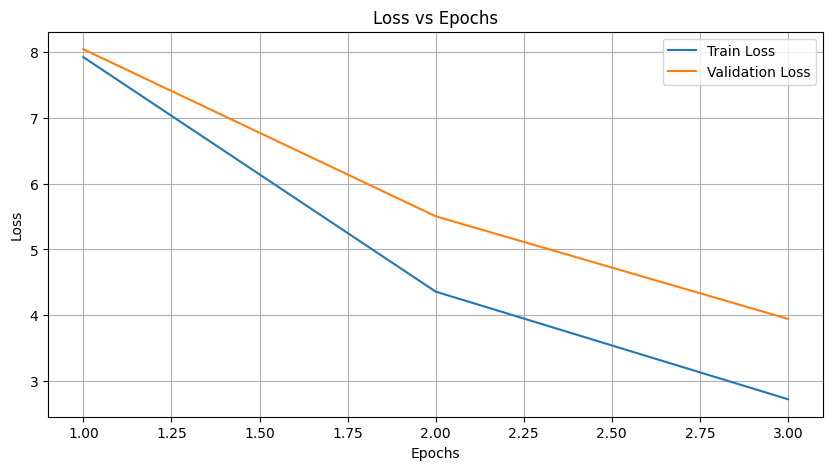

Loss plot saved successfully.


In [31]:

train_losses = np.load(os.path.join(output_training_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(output_training_dir, "val_losses.npy"))

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_dir, "loss_vs_epochs.png"))
plt.show()

print("Loss plot saved successfully.")



# Prediction Visualization Function

In [38]:
import random

In [39]:
# Prediction Visualization Function with Debugging
def visualize_predictions(model, val_loader, num_samples=5):
    model.eval()
    batch = random.choice(list(val_loader))  # Randomly select a batch
    images, _, labels = batch
    images, labels = images.to(device).float(), labels.to(device).long()

    batch_size = len(images)
    print(f"Batch size: {batch_size}, Requested num_samples: {num_samples}")

    # Ensure num_samples does not exceed batch size
    num_samples = min(num_samples, batch_size)

    with torch.no_grad():
        outputs = model(pixel_values=images).logits
        predictions = torch.argmax(outputs, dim=1)

    for i in range(num_samples):
        if i >= batch_size:
            print(f"Error: Index {i} is out of bounds for batch size {batch_size}")
            continue  # Skip invalid indices

        image_id = f"image_{i}"  # Assuming IDs are sequential, modify if necessary
        combined_path = os.path.join(output_visualization_dir, f"{image_id}_combined.png")

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[i].cpu().permute(1, 2, 0).numpy().squeeze())
        axs[0].set_title(f"Input Image (ID: {image_id})")
        axs[0].axis("off")

        axs[1].imshow(labels[i].cpu().numpy().squeeze(), cmap="gray")
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

        axs[2].imshow(predictions[i].cpu().numpy().squeeze(), cmap="gray")
        axs[2].set_title("Predicted Segmentation")
        axs[2].axis("off")

        plt.tight_layout()
        plt.savefig(combined_path)
        # plt.close()
        print(f"Saved: {combined_path}")

    print("All predictions saved successfully.")



In [42]:

visualize_predictions(model, val_loader, num_samples=12)

Output hidden; open in https://colab.research.google.com to view.